In [ ]:
!pip install kaggle

In [2]:
!pip install kaggle


In [3]:
# using kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download sumansid/facemask-dataset

Dataset URL: https://www.kaggle.com/datasets/sumansid/facemask-dataset
License(s): other
 87% 100M/114M [00:00<00:00, 1.04GB/s]
100% 114M/114M [00:00<00:00, 1.03GB/s]


In [5]:
!unzip -q /content/facemask-dataset.zip -d ./dataset

In [6]:
# Load dataset
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

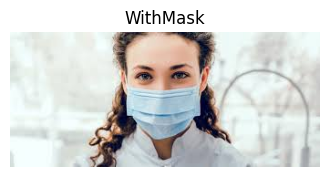

In [8]:
plt.figure(figsize=(4,4))
filepath = "/content/dataset/Mask/Mask/Mask110.jpeg"
image = imread(filepath)
plt.imshow(image)
plt.title('WithMask',fontsize=12)
plt.axis('off')
plt.show()

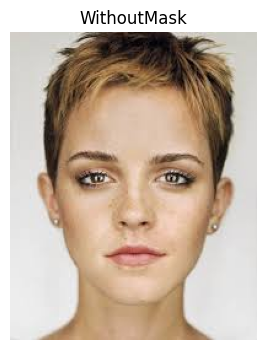

In [9]:
plt.figure(figsize=(4,4))
filepath = "/content/dataset/No Mask/No Mask/No Mask82.jpeg"
image = imread(filepath)
plt.imshow(image)
plt.title('WithoutMask',fontsize=12)
plt.axis('off')
plt.show()

In [10]:
# Prepare dataset
import os
import shutil
from pathlib import Path

# Define paths
base_dir = Path("/content/dataset/")
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/val"

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [11]:
# Move files (80% train, 20% validation)
for category in ["Mask", "No Mask"]:
    os.makedirs(f"{train_dir}/{category}", exist_ok=True)
    os.makedirs(f"{val_dir}/{category}", exist_ok=True)

    images = list((base_dir / category / category).glob("*.*"))
    split = int(0.8 * len(images))

    for img in images[:split]:
        shutil.move(str(img), f"{train_dir}/{category}")

    for img in images[split:]:
        shutil.move(str(img), f"{val_dir}/{category}")

print("Dataset organized into training and validation sets.")

Dataset organized into training and validation sets.


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
# Data Preprocessing
# Define image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Create ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)  # Only rescaling

# Load images from directory
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

Found 269 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [14]:
# Build CNN model
# ResNet152V2

base_model = tf.keras.applications.ResNet152V2(include_top=False, weights="imagenet", input_shape=(128,128,3), classifier_activation='sigmoid')

# Freeze convolutional base for feature extraction
base_model.trainable = False

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization

model = Sequential()

model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(1,activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_data,
    epochs=8,
    validation_data=val_data
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 111s 9s/step - accuracy: 0.7162 - loss: 0.7781 - val_accuracy: 0.9412 - val_loss: 2.5830
Epoch 2/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - accuracy: 0.9686 - loss: 0.3002 - val_accuracy: 0.9412 - val_loss: 1.7212
Epoch 3/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 69s 8s/step - accuracy: 0.9600 - loss: 0.1430 - val_accuracy: 0.9412 - val_loss: 1.4595
Epoch 4/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 67s 7s/step - accuracy: 0.9592 - loss: 0.2338 - val_accuracy: 0.9559 - val_loss: 1.0893
Epoch 5/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 73s 8s/step - accuracy: 0.9730 - loss: 0.1246 - val_accuracy: 0.9559 - val_loss: 0.9716
Epoch 6/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - accuracy: 0.9707 - loss: 0.1153 - val_accuracy: 0.9559 - val_loss: 0.9204
Epoch 7/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 72s 8s/step - accuracy: 0.9668 - loss: 0.1958 - val_accuracy: 0.9559 - val_loss: 0.8537
Epoch 8/8
9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - accuracy: 0.9867 - loss: 0.0483 - val_accuracy: 0.9559 - val_loss: 0.8730


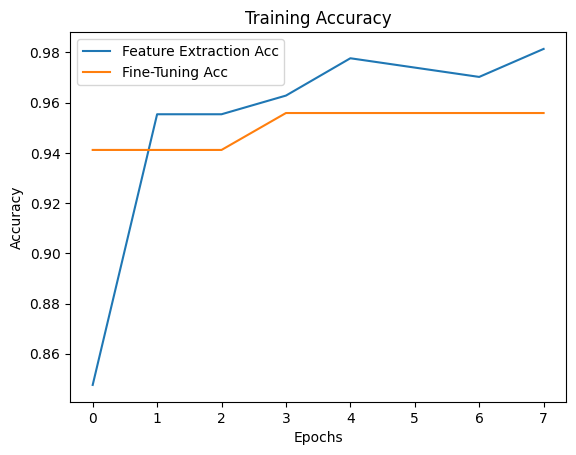

In [17]:
# Plot Training Results
plt.plot(history.history['accuracy'], label='Feature Extraction Acc')
plt.plot(history.history['val_accuracy'], label='Fine-Tuning Acc')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.show()

In [18]:
model.save("Face_Mask_Classifier_ResNet152V2_V4.h5")
print("Model saved successfully!")

Model saved successfully!


In [19]:
# Evaluate on Validation Data
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.9506 - loss: 0.8328
Validation Accuracy: 0.96


In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_true = []
y_pred = []
steps = len(val_data)  # Number of batches
for _ in range(steps):
    x, y = next(val_data)  # Get one batch
    pred_probs = model.predict(x, verbose=0)
    pred_labels = (pred_probs > 0.5).astype(int).flatten()

    # Store correct labels and predictions
    y_true.extend(y.flatten().tolist())
    y_pred.extend(pred_labels.tolist())

# Convert to NumPy arrays
y_true = np.array(y_true, dtype='int')
y_pred = np.array(y_pred, dtype='int')

# Step 3: Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

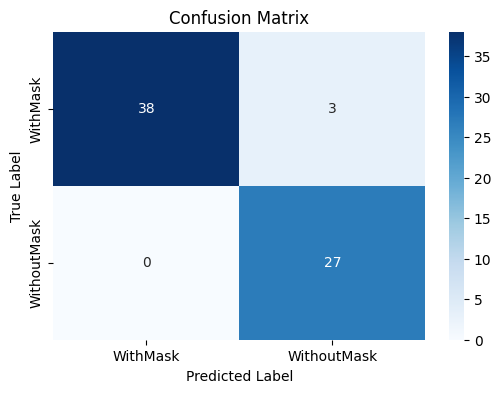

In [21]:
# Step 4: Visualize Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['WithMask', 'WithoutMask'], yticklabels=['WithMask', 'WithoutMask'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [22]:
report = classification_report(y_true, y_pred, target_names=['WithMask', 'WithoutMask'])
print(report)

              precision    recall  f1-score   support

    WithMask       1.00      0.93      0.96        41
 WithoutMask       0.90      1.00      0.95        27

    accuracy                           0.96        68
   macro avg       0.95      0.96      0.95        68
weighted avg       0.96      0.96      0.96        68



In [25]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=IMG_SIZE)  # Changed line
    img_array = tf.keras.utils.img_to_array(img) / 255.0  # Normalize # Changed line
    img_array = np.expand_dims(img_array, axis=0)  # Reshape for model

    prediction = model.predict(img_array)[0][0]
    # print(prediction)
    label = "WithoutMask" if prediction > 0.5 else "WithMask"

    if prediction <= 0.5:
      print(f"Prediction: {label} (Confidence: {1 - prediction:.2f})")

    else:
      print(f"Prediction: {label} (Confidence: {prediction:.2f})")

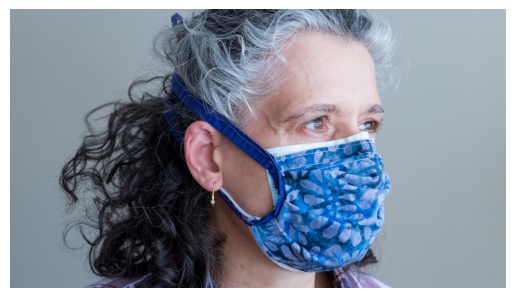

In [27]:
img_path = 'maskon.jpg'
image=imread(img_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [28]:
predict_image(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Prediction: WithMask (Confidence: 1.00)


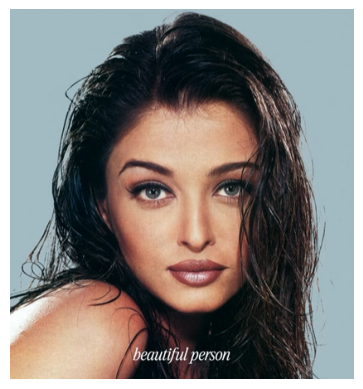

In [30]:
img_path2 = 'facewithmask.jpg'
image2=imread(img_path2)
plt.imshow(image2)
plt.axis('off')
plt.show()

In [31]:
predict_image(img_path2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Prediction: WithoutMask (Confidence: 1.00)
